In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(train_images,train_labels),(test_images,test_labels)=tf.keras.datasets.mnist.load_data()
train_images.shape

11501568/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [2]:
import numpy as np
import random

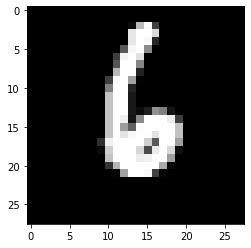

In [4]:
plt.imshow(train_images[random.randint(0,59999)],cmap='gray')
plt.show()

In [5]:
train_images[0].max()

255

In [6]:
train_images=train_images.reshape(train_images.shape[0],28,28,1)
train_images.shape

(60000, 28, 28, 1)

In [7]:
train_images=(train_images/255).astype('float32')
train_images[random.randint(0,59999)].max(),train_images[random.randint(0,59999)].min()

(1.0, 0.0)

In [3]:
def show_images(images):
    if len(images.shape)==4:
        images=np.squeeze(images)
    fig=plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for idx in range(images.shape[0]):
        plt.subplot(4,8,idx+1)
        plt.imshow(images[idx],cmap='gray')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def show_generated_images():
    noise=np.random.randn(32,128,1)
    images=generator.predict(noise,verbose=0)
    show_images(images)

def get_figure():
    noise=np.random.randn(32,128)
    images=generator.predict(noise,verbose=0)
    images=np.squeeze(images)
    fig=plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for idx in range(images.shape[0]):
        plt.subplot(4,8,idx+1)
        plt.imshow(images[idx],cmap='gray')
        plt.axis("off")
    plt.tight_layout()
    return fig

In [9]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images)
train_dataset=train_dataset.cache()
train_dataset=train_dataset.shuffle(train_images.shape[0])
train_dataset=train_dataset.batch(128)
train_dataset=train_dataset.prefetch(64)

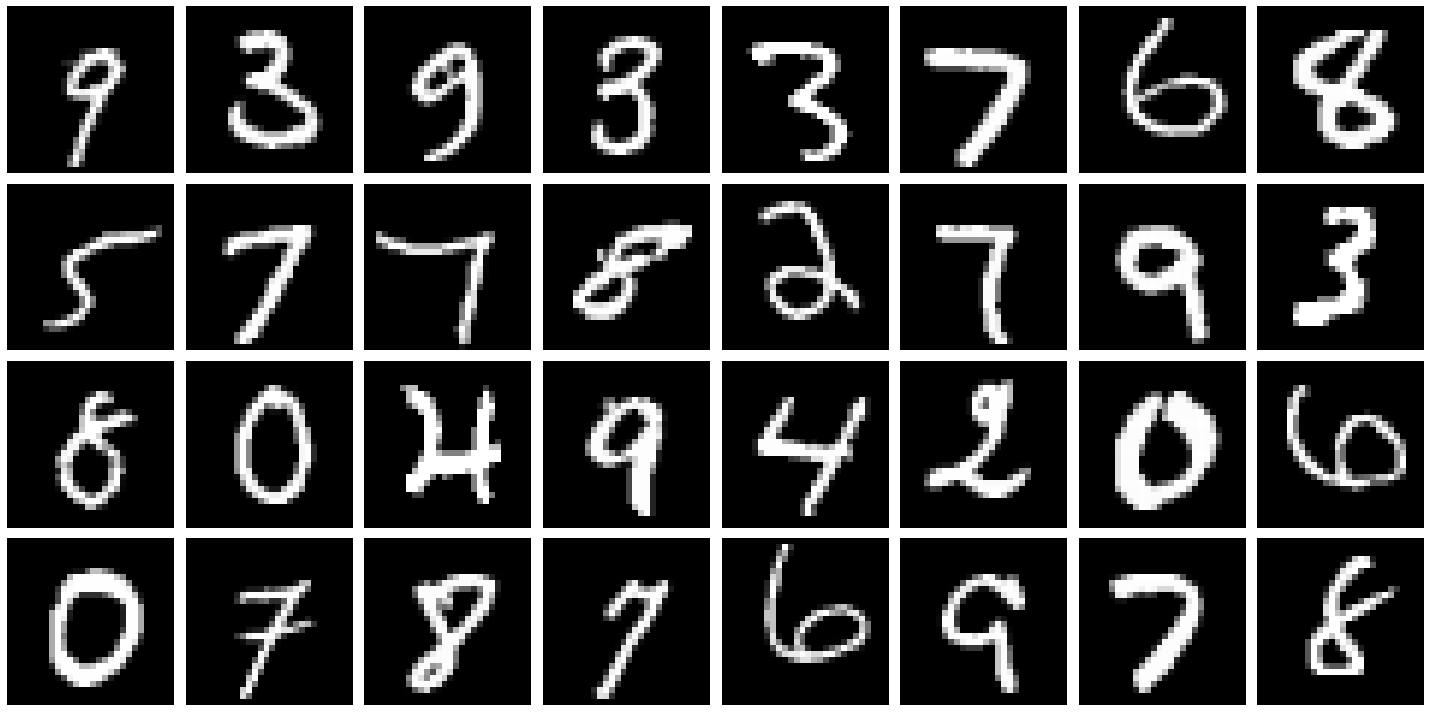

In [107]:
images=train_dataset.as_numpy_iterator().next()[:32]
show_images(images)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Reshape,LeakyReLU,Dropout,Conv2DTranspose,BatchNormalization

In [8]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())

    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1))

    return model

In [9]:
discriminator=build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         204928    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)        

In [110]:
# discriminator(generator(np.random.rand(4,128,1).astype('float32')))

In [10]:
def build_generator():
    model=tf.keras.Sequential()

    model.add(Dense(7*7*64,input_shape=(128,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7,7,64)))

    model.add(Conv2DTranspose(32,(3,3),2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1,(3,3),strides=(2,2),padding='same',activation='sigmoid'))
    
    return model

In [11]:
generator=build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3136)              404544    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       18464     
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)      

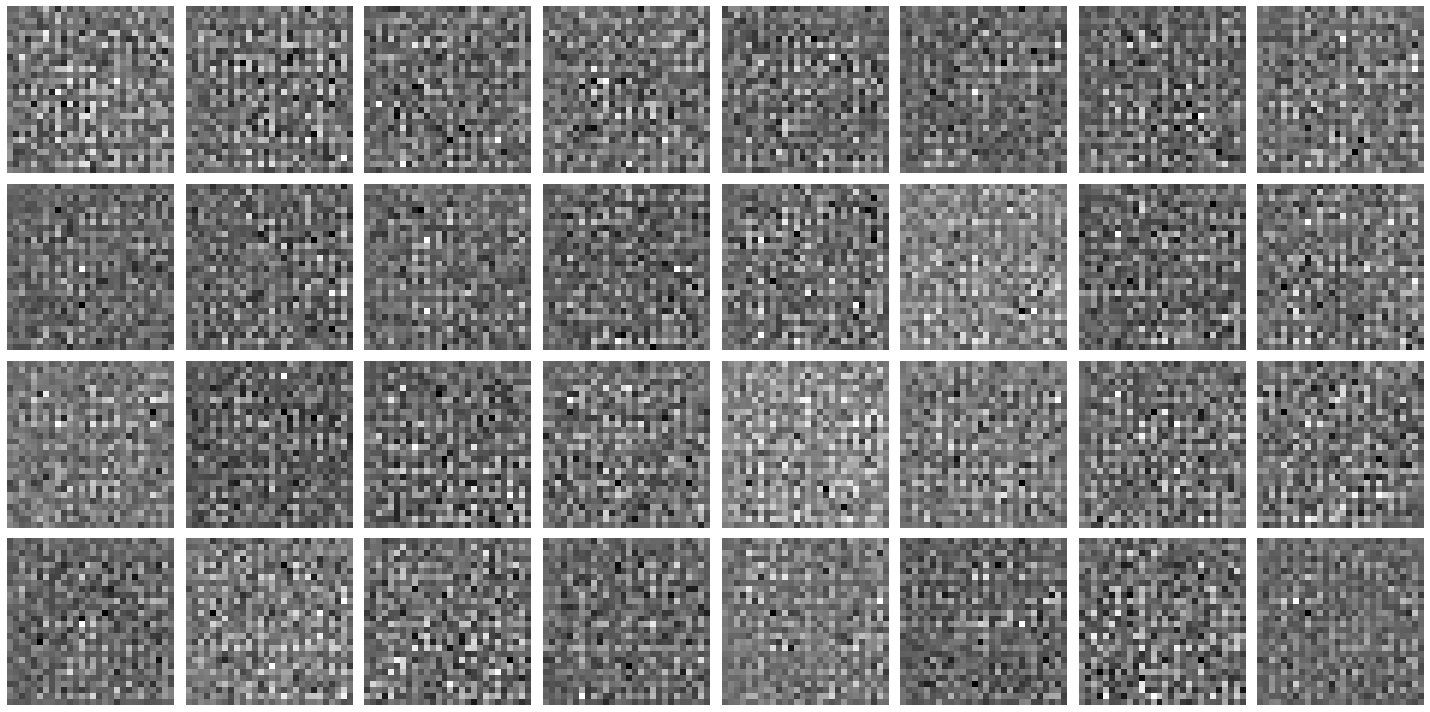

In [113]:
show_generated_images()

In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [10]:
generator_opt=Adam(1e-4)
discriminator_opt=Adam(1e-4)

generator_loss=BinaryCrossentropy()
discriminator_loss=BinaryCrossentropy()

In [4]:
from tensorflow.keras import Model

In [11]:
class DCgan(Model):
    def __init__(self,generator,discriminator,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.generator=generator
        self.discriminator=discriminator
    
    def compile(self,generator_opt,discriminator_opt,generator_loss,discriminator_loss,*args,**kwargs):
        super().compile(*args,**kwargs)
        self.generator_opt=generator_opt
        self.discriminator_opt=discriminator_opt
        self.generator_loss=generator_loss
        self.discriminator_loss=discriminator_loss

    def train_step(self,batch):
        fake_images=self.generator(tf.random.normal((128,128,1)),training=False)
        real_images=batch

        with tf.GradientTape() as d_tape:
            yhat_real=self.discriminator(real_images,training=True)
            yhat_fake=self.discriminator(fake_images,training=True)
            yhat_realfake=tf.concat([yhat_real,yhat_fake],axis=0)
            
            y_realfake=tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)

            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.discriminator_loss(y_realfake, yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.discriminator_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            predicted_labels = self.discriminator(gen_images, training=False)

            total_g_loss = self.generator_loss(tf.zeros_like(predicted_labels), predicted_labels) 
        
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.generator_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {'d_loss':total_d_loss,'g_loss':total_g_loss}

In [12]:
dcgan=DCgan(generator,discriminator)
dcgan.compile(generator_opt,discriminator_opt,generator_loss,discriminator_loss)

In [5]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import pandas as pd

In [120]:
class ModelMonitor(Callback):
    def __init__(self,num_images=1,latent_dim=128):
        self.num_images=num_images
        self.latent_dim=latent_dim
    
    def on_epoch_end(self,epoch,logs=None):
        generated_images=generator(np.random.randn(self.num_images,self.latent_dim,1),training=False)
        generated_images=(generated_images*255)
        generated_images=tf.cast(generated_images,dtype=np.int32)
        for i in range(self.num_images):
            img=array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/MyDrive/generated',f'generated_img_{epoch}.{i}.jpg'))

In [121]:
history=dcgan.fit(train_dataset,epochs=500,callbacks=[ModelMonitor()])

Epoch 1/200
469/469 [==============================] - 9s 16ms/step - d_loss: 0.6855 - g_loss: 0.5086
Epoch 2/200
469/469 [==============================] - 7s 16ms/step - d_loss: 0.6733 - g_loss: 0.7319
Epoch 3/200
469/469 [==============================] - 7s 15ms/step - d_loss: 0.6589 - g_loss: 0.7870
Epoch 4/200
469/469 [==============================] - 7s 15ms/step - d_loss: 0.5570 - g_loss: 1.1258
Epoch 5/200
469/469 [==============================] - 7s 15ms/step - d_loss: 0.6557 - g_loss: 0.8258
Epoch 6/200
469/469 [==============================] - 7s 15ms/step - d_loss: 0.6069 - g_loss: 0.7796
Epoch 7/200
469/469 [==============================] - 7s 15ms/step - d_loss: 0.6472 - g_loss: 0.7713
Epoch 8/200
469/469 [==============================] - 7s 15ms/step - d_loss: 0.6346 - g_loss: 0.8049
Epoch 9/200
469/469 [==============================] - 8s 16ms/step - d_loss: 0.6278 - g_loss: 0.9021
Epoch 10/200
469/469 [==============================] - 7s 15ms/step - d_loss: 0.6

FileNotFoundError: ignored

In [20]:
df=pd.DataFrame(history.history)
df.to_csv('model_loss.csv',index=False)

In [6]:
generator=tf.keras.models.load_model(os.path.join('models','generator.h5'))
discriminator=tf.keras.models.load_model(os.path.join('models','discriminator.h5'))

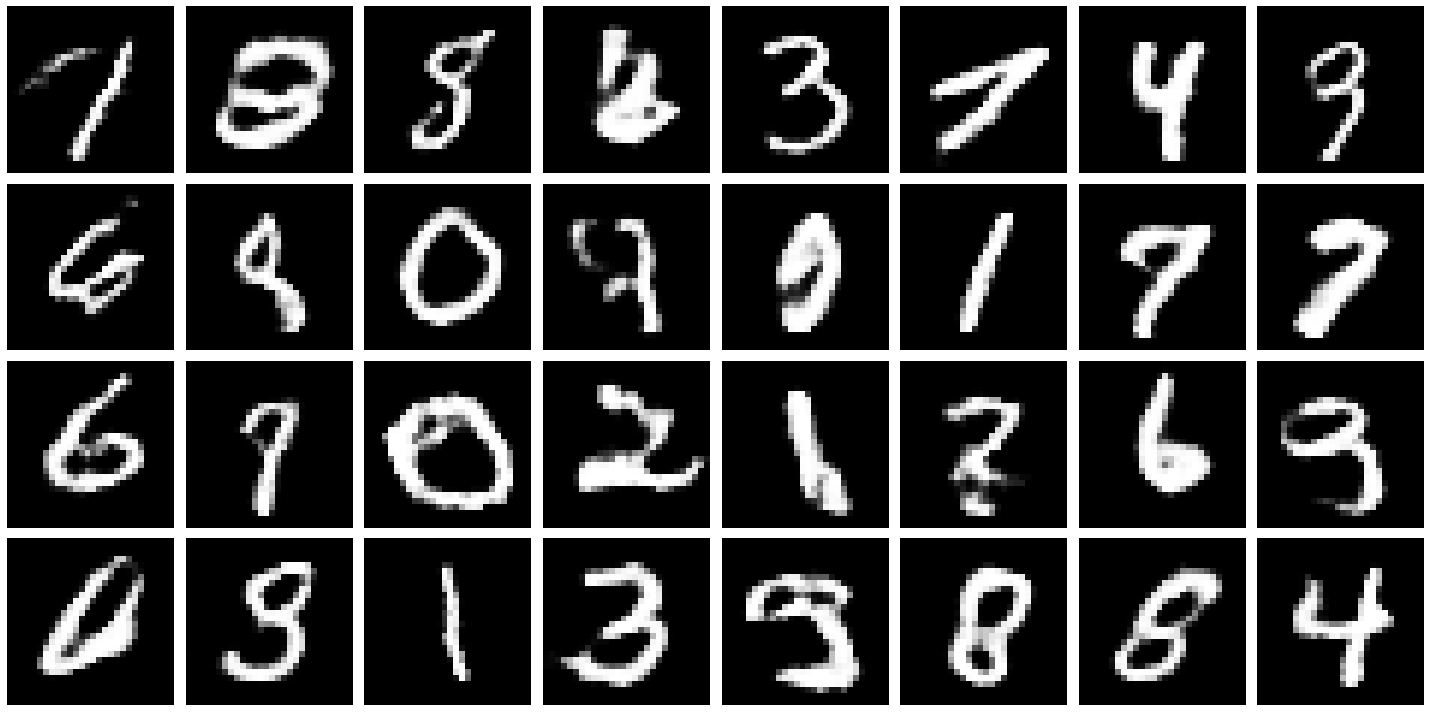

In [20]:
show_generated_images()

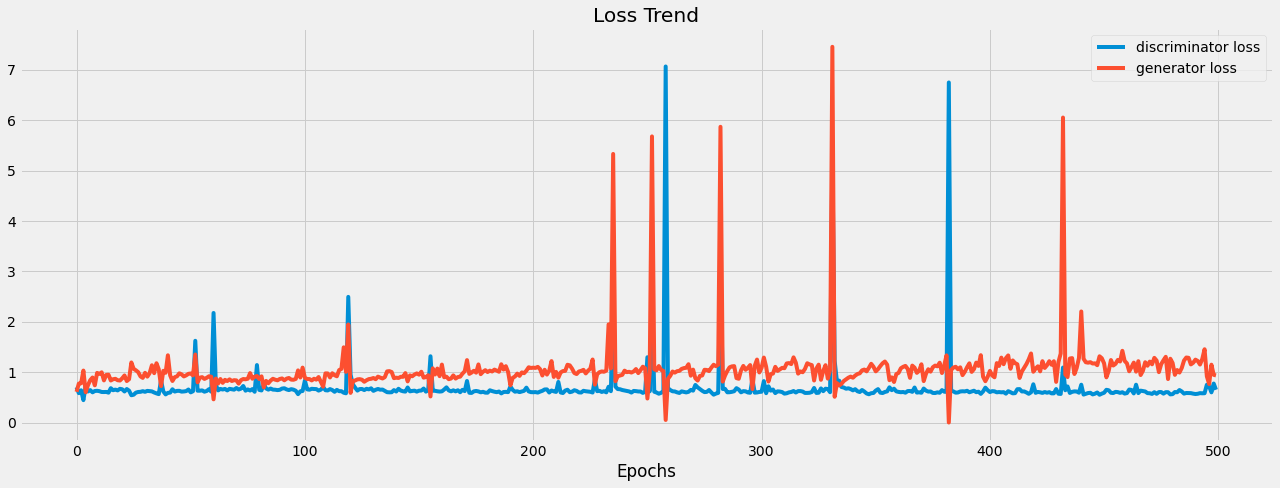

In [32]:
df=pd.read_csv('model_loss.csv')
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18,7))
plt.plot(df['d_loss'],label='discriminator loss')
plt.plot(df['g_loss'],label='generator loss')
plt.xlabel('Epochs')
plt.title('Loss Trend')
plt.legend()
plt.tight_layout()
plt.show()

In [123]:
# ------------!!!  CAUTION  !!!---------------------

# tf.keras.models.save_model(generator,os.path.join('models','generator.h5'))
# tf.keras.models.save_model(discriminator,os.path.join('models','discriminator.h5'))